# LSTM Production
Notebook to put LSTM into production on AWS

In [1]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import sqlalchemy
from sqlalchemy import create_engine
import s3fs

from functools import partial
import ray
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.suggest.hyperopt import HyperOptSearch
from ray.tune.stopper import TrialPlateauStopper

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from dotenv import load_dotenv

/opt/conda/envs/pytorch/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model

In [23]:
class Net(nn.Module):
    
    def __init__(self, input_size, hidden_size=8, num_lstm_layers=1, dropout=0):
        super().__init__()
        if num_lstm_layers == 1:
            dropout = 0
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_size,
                            num_layers=num_lstm_layers,
                            dropout=dropout)
        self.fc1 = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        x = self.fc1(lstm_out)
        return x

### Train Function

In [6]:
def train_lstm(config, train_X, train_y, val_X, val_y, checkpoint_dir=None,):

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
    
    print(f"DEVICE: {device}")
    train_X = train_X.to(device)
    train_y = train_y.to(device)
    val_X = val_X.to(device)
    val_y = val_y.to(device)
    
    # Configure the network and send it to the device
    # Width of the dataframe - 1 (y variable) is feature set size 
    input_size = train_X.shape[2]
    net = Net(input_size=input_size,
              hidden_size=config['hidden_size'],
              num_lstm_layers=config['num_lstm_layers'],
              dropout=config['dropout'])
    
    if torch.cuda.device_count() > 1:
        net = nn.DataParallel(net)     
    net.to(device)
    
    optimizer = optim.Adam(net.parameters(), lr=config['learning_rate'])
    optimizer
    
    # Checkpoint Dir Stuff -- handled by Tune 
    if checkpoint_dir:
        checkpoint = os.path.join(checkpoint_dir, "checkpoint")
        model_state, optimizer_state = torch.load(checkpoint)
        net.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)    
    
    # train
    BATCH_SIZE = config['batch_size']
    for epoch in range(1000):
        epoch_start = datetime.now()
        print(f"Epoch: {epoch}")
        running_loss = 0
        epoch_steps = 0
        for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
            X = train_X[i:i+BATCH_SIZE]
            y = train_y[i:i+BATCH_SIZE]
            net.zero_grad()
            
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            epoch_steps += 1
            
            # Print loss every 1000 batches
            if i % 100 == 99:
                avg_loss = running_loss / epoch_steps
                print(f"Epoch {epoch}, steps {epoch_steps-1000}:{epoch_steps} avg loss: {avg_loss}")
                running_loss = 0 
                
        # Validate each epoch
        val_loss = 0
        val_steps = 0
        with torch.no_grad():
            for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
                X = val_X[i:i+BATCH_SIZE]
                y = val_y[i:i+BATCH_SIZE]
                out_seq = net(X)
                first_dim, second_dim, _ = out_seq.shape
                pred = out_seq.view(first_dim, second_dim)[:, -1]
                loss = F.mse_loss(pred, y)
                val_loss += loss.item()
                val_steps += 1
        
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            torch.save((net.state_dict(), optimizer.state_dict()), path)
            
        tune.report(val_loss=(val_loss/val_steps), train_loss=(running_loss/epoch_steps), training_iteration=epoch)
        print(f"Finished epoch {epoch} in {datetime.now()-epoch_start}")
    print("finished!")

### Load and Process data

In [4]:
s3 = s3fs.S3FileSystem()
print("Loading train X")
with s3.open("s3://bgpredict/models/lstm/tensors/train_X", 'rb') as f:
    train_X=torch.load(f)
print("Loading train y")
with s3.open("s3://bgpredict/models/lstm/tensors/train_y", 'rb') as f:
    train_y=torch.load(f)
print("Loading Val X")
with s3.open("s3://bgpredict/models/lstm/tensors/val_X", 'rb') as f:
    val_X=torch.load(f)    
print("Loading Val y")
with s3.open("s3://bgpredict/models/lstm/tensors/val_y", 'rb') as f:
    val_y=torch.load(f)    

torch.Size([572731, 12, 171])

In [3]:
torch.cuda.is_available()

True

In [72]:
ray.shutdown()
ray.init()

RayContext(dashboard_url='', python_version='3.9.13', ray_version='1.13.0', ray_commit='e4ce38d001dbbe09cd21c497fedd03d692b2be3e', address_info={'node_ip_address': '172.31.34.141', 'raylet_ip_address': '172.31.34.141', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-07-28_17-51-40_585463_6931/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-07-28_17-51-40_585463_6931/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-07-28_17-51-40_585463_6931', 'metrics_export_port': 64489, 'gcs_address': '172.31.34.141:54483', 'address': '172.31.34.141:54483', 'node_id': 'c95972cabea5ccba77e8e12cf131be8d8bbf17b56b959bfde848c127'})

In [7]:
config= {
    'hidden_size': tune.choice([2**x for x in range(3, 9)]), # 2^3 to 2^8, 8 to 256
    'num_lstm_layers':tune.choice([1,2,3,4,5]),
    'dropout': tune.choice([0, 0.1, 0.2, 0.3, 0.4, 0.5]), # [0,0.5]
    'learning_rate': tune.choice([0.00001, 0.0001, 0.001, 0.01, 0.1]),
    'batch_size': tune.choice([2**x for x in range(3, 9)]), # 2^3 to 2^8, 8 to 256
}

initial_params = [{"hidden_size": 128,
                  "num_lstm_layers": 1,
                  "dropout": 0,
                  "batch_size": 128,
                  'learning_rate': 0.1}]

def stopper(trial_id, result):
    if result['training_iteration'] > 100:
        return True
    elif result['val_loss'] < 5:
        return True
    else:
        return False


hyperopt_search = HyperOptSearch(metric='val_loss', mode='min', points_to_evaluate=initial_params)

scheduler = ASHAScheduler(
    time_attr="training_iteration",
    metric="val_loss",
    mode="min")

reporter = JupyterNotebookReporter(
    metric_columns = ["val_loss", "loss", "training_iteration"],
    overwrite=False,
    max_report_frequency=60
)


result = tune.run(
    tune.with_parameters(
        train_lstm,
        train_X = train_X,
        train_y = train_y,
        val_X = val_X,
        val_y = val_y
    ),
    resources_per_trial={"cpu":1, "gpu":1},
    config=config,
    num_samples=16,
    # progress_reporter=reporter,
    search_alg=hyperopt_search,
    name='GPU',
    stop = stopper
)

NameError: name 'train_X' is not defined

In [80]:
best_trial = result.get_best_trial('val_loss', 'min', 'last')

In [81]:
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))

Best trial config: {'hidden_size': 128, 'num_lstm_layers': 2, 'dropout': 0.4, 'learning_rate': 0.01, 'batch_size': 16, 'epoch': 500}
Best trial final validation loss: 153.73668900851547


In [8]:
# Save directory
best_dir = result.get_best_logdir(metric='val_loss', mode='min')
splits = best_dir.split("/")
folder = best_dir.split(splits[-1])[0]
s3 = s3fs.S3FileSystem()
s3.put(folder, "bgpredict/models/lstm/cpu", recursive=True)

NameError: name 'result' is not defined

In [82]:
dfs = result.trial_dataframes

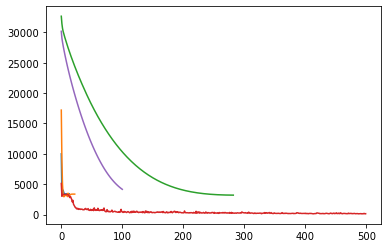

In [83]:
ax = None  # This plots everything on the same plot
for d in dfs.values():
    ax = d.val_loss.plot(ax=ax, legend=False)

In [31]:
net = Net(input_size=train_X.shape[2], 
          hidden_size = best_trial.config['hidden_size'],
          num_lstm_layers=best_trial.config['num_lstm_layers'],
          dropout= best_trial.config['dropout']
)

In [32]:
losses = []
val_losses = []
BATCH_SIZE = 8
learning_rate = best_trial.config['learning_rate']
optimizer = optim.Adam(net.parameters(), lr=learning_rate)
iter_idx = 0 
running_loss = 0
epoch_steps = 0
# train_y = tensorset.train_y
# for epoch in range(best_trial.config['epoch']):
for epoch in range(5):
    print(f"Epoch: {epoch}")
    for i in range(0, len(train_X)-BATCH_SIZE, BATCH_SIZE):
        X = train_X[i:i+BATCH_SIZE]
        y = train_y[i:i+BATCH_SIZE]
        net.zero_grad()

        out_seq = net(X)
        first_dim, second_dim, _ = out_seq.shape
        pred = out_seq.view(first_dim, second_dim)[:, -1]
        loss = F.mse_loss(pred, y)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        epoch_steps += 1

        # Print loss every 1000 batches
        if i % 100 == 99:
            avg_loss = running_loss / epoch_steps
            print(f"Epoch {epoch}, steps {epoch_steps-1000}:{epoch_steps} avg loss: {avg_loss}")
            running_loss = 0 
        
        
    # Validate each epoch
    val_loss = 0
    val_steps = 0
    with torch.no_grad():
        for i in range(0, len(val_X)-BATCH_SIZE, BATCH_SIZE):
            X = val_X[i:i+BATCH_SIZE]
            y = val_y[i:i+BATCH_SIZE]
            out_seq = net(X)
            first_dim, second_dim, _ = out_seq.shape
            pred = out_seq.view(first_dim, second_dim)[:, -1]
            loss = F.mse_loss(pred, y)
            val_loss += loss.item()
            val_steps += 1
        
    print("Loss:", loss)    
    print("val_loss:", val_loss)

Epoch: 0


KeyboardInterrupt: 

In [203]:
losses_plt = [i.item() for i in losses]
val_losses_vals = [i[0].item() for i in val_losses]
val_losses_idx = [i[1] for i in val_losses]

In [248]:
out_seq = net(test_X)
first_dim, second_dim, _ = out_seq.shape
pred = out_seq.view(first_dim, second_dim)[:, -1]

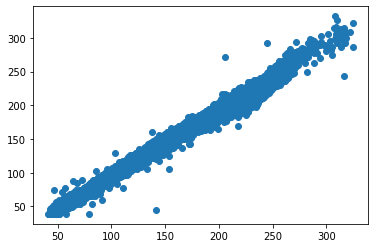

In [249]:
pred_array = pred.detach().numpy()
y = test_y.detach().numpy()
plt.scatter(pred_array, y)

In [214]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score

In [250]:
mse = mean_squared_error(y, pred_array)
print(np.sqrt(mse))

6.5817876


In [251]:
mean_absolute_percentage_error(y, pred_array)

0.041773885

In [252]:
mean_absolute_error(y,pred_array)

4.830085